In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math

from scipy import spatial

color_list =["#3eb991","#e9a820","#e01563","#edb196","#6ecadc","#1f94ac","#ae9a6a","#ccb8a6","#343a44"]

In [132]:
# defining function for diffusion in 3D over time
def single_step(X, Y, theta, delta_T):

    # defining variables
    v = 1 * pow(10, -6); 
    omega = 0; 
    D_r = 0.05; 
    D_t = 0.1 * pow(10, -12); 

    delta_X, delta_Y = 0, 0; 
    delta_theta = 0; 
 
    # randomly sampling in a uniform distribution from 0 to 1 to get an angle
    W_theta = (math.pi / 2) * np.random.uniform(-1, 1); 

    # randomly sampling noise in Gaussian distrib. with mean 0 and variance 1
    W_X = np.random.normal(0, 1); 
    W_Y = np.random.normal(0, 1); 

    # solving change in position for each dimension
    delta_X = v * np.cos(theta) * delta_T + np.sqrt(2 * D_t * delta_T) * W_X; 
    delta_Y = v * np.sin(theta) * delta_T + np.sqrt(2 * D_t * delta_T) * W_Y; 

    # solving change in each angle
    delta_theta = omega * delta_T + np.sqrt(2 * D_r * delta_T) * W_theta; 

    # using a temporary variable to track position and angle
    X += delta_X; 
    Y += delta_Y; 
    theta += delta_theta; 

    temp_postition = []; 
    temp_postition = np.array([X, Y, theta]); 

    return temp_postition; # returning coordinates and diffusion coefficient (for comparison later)

In [133]:
class makeSwimmer: # defines swimmer class
  def __init__(self, x, y, theta, start_time, parent): # one can enter with 0, 0, 0 start or other
    self.start_time = start_time; 
    self.position = np.array([[x, y, theta]]); 
    self.parent = parent; # the index of the swimmer you diverged from (in the list)
    self.density = 0; # finding the density of nearby swimmers
    self.swimming = True; # this will define if the swimmer is swimming or still, True = swim, False = still
    self.stall_time = 0; 
    self.down_time = 0; 
    self.down = False; 
    # notes: 
    # [done?] make divide time, subtract from current time, use this to induce stalling --- built in cool down
    # [done?] need second stalling metric, for when local density is high enough
    # [done?] will also need some metric of ensuring movement for some time after movement resumes

In [134]:
def find_probability(density, delta_T):
    sigma = 2; 
    mean = 5; 
    max = 0.5 * (1 / pow(2 * math.pi, 0.5)) * np.exp(- 0.5 * pow(((mean - mean) / sigma), 2)); # used to normalize
    probability = (1 / max) * 0.5 * (1 / pow(2 * math.pi, 0.5)) * np.exp(- 0.5 * pow(((density - mean) / sigma), 2)); # normalized to 1

    bool_temp = False; 
    if probability > np.random.uniform(0, 1): 
        bool_temp = True; 
      
    return bool_temp; 

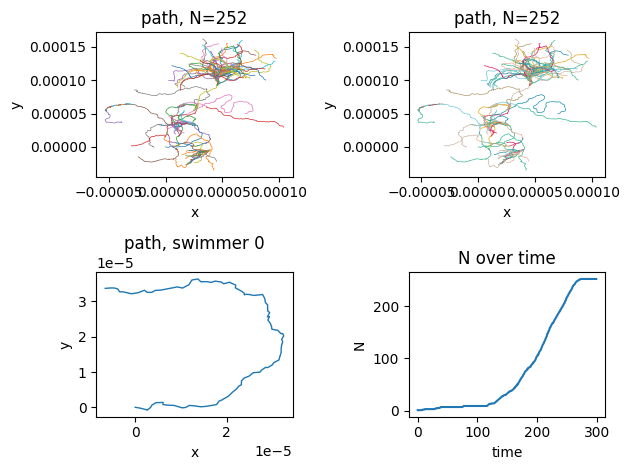

In [135]:
total_time = 300; # in seconds?
delta_T = 1; 
indexed_time = int(total_time / delta_T); # used to index through time list
swimmer_Radius = 1 * pow(10, -7); # this is the swimmer size (too small?), so that when they divide their centers will be offset by this

swimmerList = []; # a list of swimmers
for i in range(0, 1, 1): # initializes a list of 10 swimmers
    swimmerList.append(makeSwimmer(0, 0, 0, 0, 0)); # set starting point at 0, 0

population_size = []; 
start_times = [0]; # will be helpful later and save a ton of comp. power

temp_coords_list = np.array([[0, 0]]); 
for time in range(0, indexed_time, 1):
    population_size.append(len(swimmerList)); 

    # this is used to find the nearest swimmer
    # let us instead try to convert this module to density of nearby swimmers
    temp_coords_list = np.delete(temp_coords_list, 0, 0); # removes first element of array, I think

    for i in range(0, len(swimmerList), 1):

        time_effective = time - swimmerList[i].start_time; # to make using the start time easier
        compare_coord = [[swimmerList[i].position[time_effective, 0], swimmerList[i].position[time_effective, 1]]]; # stores current position
        distances = spatial.distance.cdist(temp_coords_list, compare_coord).flatten(); # flatten added to reduce to 1D array
        distances = distances[distances != 0]; # used to remove / extract non-zero numbers (i.e., self)

        if swimmerList[i].swimming: # boolean value for if the swimmer is swimming or still
            local_density = 0;
            for distance in distances:
                if distance < 0.0001: # 1 mm
                    local_density += 1; # increases for swimmers in this range
                    # note that if not satisfied, local density = 0, which is correct
            swimmerList[i].density = local_density; # stores local density

    temp_coords_list = np.array([[0, 0]]); 

    for i in range(0, len(swimmerList), 1):

        time_effective = time - swimmerList[i].start_time; # to make using the start time easier
        arr = swimmerList[i].position[time_effective]; # to store the previous position

        if swimmerList[i].swimming: # checks if swimmer is swimming
            temp_coords = single_step(arr[0], arr[1], arr[2], delta_T); # stores its current coordinates
            swimmerList[i].position = np.vstack((swimmerList[i].position, temp_coords)); # adds new dt coordinates
            temp_coords_list = np.vstack((temp_coords_list, [temp_coords[0], temp_coords[1]])); # adds current coordinates to a list with other swimmers current coordinates
            if swimmerList[i].down and swimmerList[i].down_time >= 0: # if swimmer is in down_time and down_time still >= 0
                swimmerList[i].down_time = swimmerList[i].down_time - delta_T; # subtracts dt from downtime
            else: # condition when the swimmer is not on down_time
                swimmerList[i].down_time = 0; # sets down_time to be 0
                swimmerList[i].down = False; # sets down boolean to be False
        elif swimmerList[i].stall_time >= 0: # condition for if the swimmer is stalled (i.e., dividing)
            # note: I think it must be geq; consider the case when stall_time = 100 and dt = 100 for reasoning
            swimmerList[i].stall_time = swimmerList[i].stall_time - delta_T; # removes dt from stall_time
            swimmerList[i].position = np.vstack((swimmerList[i].position, [arr[0], arr[1], arr[2]])); # adds current position as next time's position
        else: # condition for if not stalled and not swimming (i.e., starting to swim again)
            swimmerList[i].swimming = True; # sets swimming back to True
            swimmerList[i].down = True; # marks the swimmer as being down (cannot divide again)
            swimmerList[i].stall_time = 0; # sets stall_time to 0
            swimmerList[i].down_time = 50; # sets down_time to 50
            swimmerList[i].position = np.vstack((swimmerList[i].position, [arr[0], arr[1], arr[2]])); # finds position at next time

        # determining probability, then using a random number generator to define division
        bool_divide = find_probability(swimmerList[i].density, delta_T); 

        if bool_divide and swimmerList[i].swimming and not swimmerList[i].down: # currently causing stoachstic cell division
            swimmerList[i].swimming = False; # causes swimmer to stop
            swimmerList[i].stall_time = 100; # sets duration of stopping
            offset = np.random.normal(0, swimmer_Radius); # just doing this so it isn't exact same length every time, will need to think of a better way to do this, probably
            x_after_divide = arr[0] + offset; # causes next swimmer to start around body length away
            y_after_divide = arr[1] + offset; 
            swimmerList.append(makeSwimmer(x_after_divide, y_after_divide, swimmerList[i].position[time_effective, 2], time + 1, i)); # set starting point at 0, 0
            start_times.append(time + 1); 
            temp_coords_list = np.vstack((temp_coords_list, [x_after_divide, y_after_divide])); 


x = []; 
y = []; 
for i in np.arange(0, len(swimmerList), 1):
    x.append(swimmerList[i].position[-1,0]); 
    y.append(swimmerList[i].position[-1,1]); 


# 2d graphing definitions
plt.subplot(2, 2, 1); # putting plots on the same image, this at row 1, col 1, index 1
for i in range(0, len(swimmerList), 1):
    plt.plot(swimmerList[i].position[:,0], swimmerList[i].position[:,1], linewidth=0.5); 
    # here, : takes all values at position 0 (x) or 1 (y) for each swimmer in the list
    # plot then graphs all of those x and y independently

plt.xlabel('x')
plt.ylabel('y')
plt.title("path, N=" + str(len(swimmerList)))
plt.tight_layout()
# plt.gca().set_aspect(0.75)

plt.subplot(2, 2, 2); # putting plots on the same image, this at row 1, col 1, index 1
for i in range(0, len(swimmerList), 1):
    plt.plot(swimmerList[i].position[:,0], swimmerList[i].position[:,1], linewidth=0.5, color = color_list[swimmerList[i % len(color_list)].parent]);
    # here, : takes all values at position 0 (x) or 1 (y) for each swimmer in the list
    # plot then graphs all of those x and y independently

plt.xlabel('x')
plt.ylabel('y')
plt.title("path, N=" + str(len(swimmerList)))
plt.tight_layout()
# plt.gca().set_aspect(0.75)

plt.subplot(2, 2, 3); # putting plots on the same image, this at row 1, col 1, index 1
plt.plot(swimmerList[0].position[:,0], swimmerList[0].position[:,1], linewidth=1); 

plt.xlabel('x')
plt.ylabel('y')
plt.title("path, swimmer 0")
plt.tight_layout()
# plt.gca().set_aspect(0.75)

plt.subplot(2, 2, 4); # putting plots on the same image, this at row 1, col 1, index 1
plt.plot(np.arange(0, total_time, delta_T), population_size); 

plt.xlabel('time')
plt.ylabel('N')
plt.title("N over time")
plt.tight_layout()
# plt.gca().set_aspect('equal')




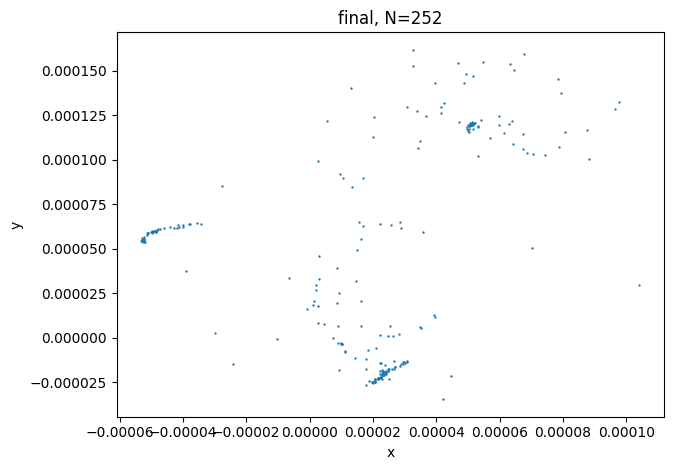

In [136]:
plt.xlabel('x')
plt.ylabel('y')
plt.title("final, N=" + str(len(swimmerList)))
plt.tight_layout()

plt.scatter(x, y, s = 0.5); 
plt.show()

In [137]:
import os
import cv2
from glob import glob

In [138]:
def graph_time(x,y,time):

    fig, ax = plt.subplots()

    plt.scatter(x, y, s = 0.5); 

    ax.set_xlim(-1e-4, 1e-4)
    ax.set_ylim(-1e-4, 1e-4)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    fig.autofmt_xdate()

    # plt.tight_layout()

    ax.set_title(f"time: {time}")

    if (time < 10):
        plt.savefig(f"../content/graphs/2D/000{time}")
    elif (time < 100):
        plt.savefig(f"../content/graphs/2D/00{time}")
    elif (time < 1000):
        plt.savefig(f"../content/graphs/2D/0{time}")
    else:
        plt.savefig(f"../content/graphs/2D/{time}")

    plt.close()

In [139]:
os.makedirs("../content/graphs/2D", exist_ok=True); 

old_files = glob("../content/graphs/2D/*.png"); 
for f in old_files:
    os.remove(f); 

In [140]:
# for time in total time get x and y in the list
# call graph thing

for time in np.arange(0, indexed_time, 10):
    j = 0; 
    while start_times[j] < time: # this might be insane or it might be genius---not sure yet
        j += 1; 
    i = 0; 
    x, y = [], []; 
    while i <= j: 
        if time >= swimmerList[i].start_time:
            time_effective = time - swimmerList[i].start_time; # to make using the start time easier
            x.append(swimmerList[i].position[time_effective, 0]); 
            y.append(swimmerList[i].position[time_effective, 1]); 
        i += 1; 
        graph_time(x, y, time); 
    print(f"{time} and {j}"); 


0 and 0
10 and 2
20 and 3
30 and 4
40 and 7
50 and 7
60 and 7
70 and 7
80 and 9
90 and 9
100 and 9
110 and 9
120 and 12
130 and 15
140 and 25
150 and 32
160 and 40
170 and 54
180 and 73
190 and 84
200 and 103
210 and 125
220 and 152
230 and 173
240 and 193
250 and 215
260 and 236
270 and 249


IndexError: list index out of range

In [141]:
image_folder = '../content/graphs/2D'; 
video_name = '../content/graphs/video.mp4'; 

fourcc = cv2.VideoWriter_fourcc(*'mp4v'); 

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]; 
frame = cv2.imread(os.path.join(image_folder, images[0])); 
height, width, layers = frame.shape; 

video = cv2.VideoWriter(video_name, fourcc, 3, (width,height)); 

print(images); 

images.sort(); 

print(images); 

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image))); 

cv2.destroyAllWindows(); 
video.release(); 

['0110.png', '0070.png', '0270.png', '0260.png', '0060.png', '0100.png', '0210.png', '0170.png', '0010.png', '0000.png', '0160.png', '0200.png', '0190.png', '0230.png', '0030.png', '0150.png', '0140.png', '0020.png', '0220.png', '0180.png', '0050.png', '0130.png', '0090.png', '0250.png', '0240.png', '0080.png', '0120.png', '0040.png']
['0000.png', '0010.png', '0020.png', '0030.png', '0040.png', '0050.png', '0060.png', '0070.png', '0080.png', '0090.png', '0100.png', '0110.png', '0120.png', '0130.png', '0140.png', '0150.png', '0160.png', '0170.png', '0180.png', '0190.png', '0200.png', '0210.png', '0220.png', '0230.png', '0240.png', '0250.png', '0260.png', '0270.png']
